# Speed control in biological sequence-generating network

Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.


## Next steps

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I = 30, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.1e-3,  # I->E input weights
    W_A=0, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


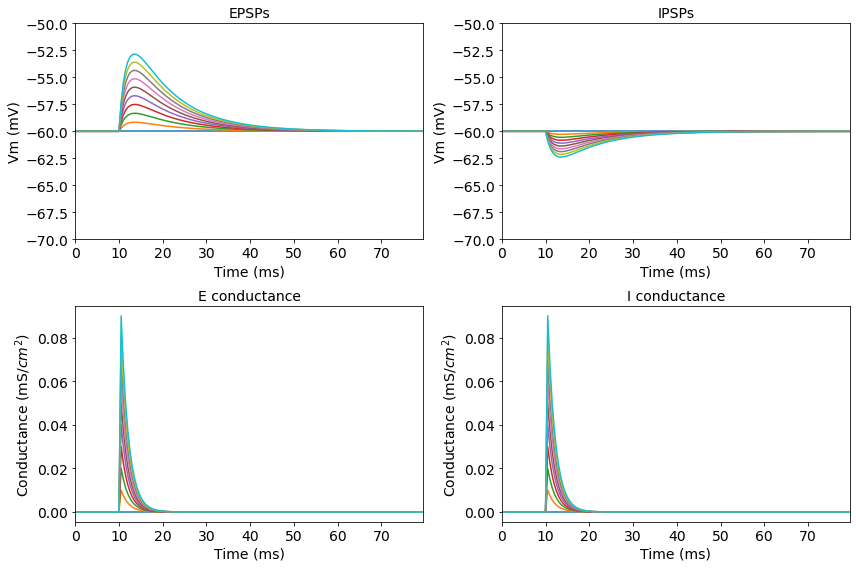

In [2]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)
rsps_e = []

for w_u_e_e in np.arange(10) * 0.01e-3:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_I},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 0] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(10) * 0.01e-3:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_E},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 1] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))

    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-70, -50)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

# Full chain

In [3]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

## Speed control via INH input

### Helper functions for defining connectivity

In [4]:
## E-E weights
def make_w_r_e(m, w_e_i_r, w_e_e_r, w_e_e_f, percent_cnxn_e_e, percent_cnxn_e_i):
    w_r_e = np.zeros([m.N_N]*2)

    w_r_e_e = w_e_e_f * np.kron(np.eye(m.N_L, k=-1), np.ones([m.N_L_E]*2))  # btwn links
    for i in range(m.N_L):
        w_r_e_e[(i * m.N_L_E):((i+1) * m.N_L_E), (i * m.N_L_E):((i+1) * m.N_L_E)] = \
            w_e_e_r * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), percent_cnxn_e_e)

    w_r_e[:m.N_E, :m.N_E] = w_r_e_e
    w_r_e[m.N_E:, :m.N_E] = w_e_i_r * sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_P_I), percent_cnxn_e_i)
    
    return w_r_e

def make_w_r_i(m, w_i_e_r):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = w_i_e_r * np.ones([m.N_E, m.N_P_I])
    return w_r_i

def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_N + m.N_L_E])
    w_u_i[:(-m.N_P_I), m.N_L_E:(-m.N_P_I)] = m.W_U_E_I * np.eye(m.N_E)
    return w_u_i

### Define function for simulating a single set of parameters using three different input UVA frequences

In [5]:
def run_test(m_t, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, w_uv, percent_cnxn_e_e, percent_cnxn_e_i,
             show_connectivity=False):
    
    w_r = {
        'E': make_w_r_e(m_t, w_e_i_r, w_e_e_r, w_e_e_f, percent_cnxn_e_e, percent_cnxn_e_i),
        'I': make_w_r_i(m_t, w_i_e_r),
        'A': m_t.W_A * np.eye(m_t.N_N),
    }

    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ 0.01 * np.eye(m_t.N_L_E), np.zeros([m_t.N_L_E, m_t.N_N]) ],
            [ np.zeros([m_t.N_N - m_t.N_L_E, m_t.N_N + m_t.N_L_E]) ],
        ]),

        # global inhibitory inputs across chain
        'I': make_w_u_i(m_t)
    }

    if show_connectivity:
        fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
        axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[0].set_title('W_R[E]\n')
        axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
        axs[1].set_title('W_R[I]\n')

        axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[2].set_title('W_U[E]\n')
        axs[3].spy(w_u['I'], markersize=1)
        axs[3].set_title('W_U[I]\n')

        for ax in axs.flatten():
#             ax.set_xlim(0, 200)
#             ax.set_ylim(200, 0)
            set_font_size(ax, 14)

    # inputs
    t = np.arange(0, S.T, S.DT)
    t_u = [.01, .013]
    t_mask = (t_u[0] <= t) & (t < t_u[1])

    ## external currents
    i_ext = m_t.SGM_N/S.DT * np.random.randn(len(t), m_t.N_N) + m_t.I_EXT_B

    ## inp spks

    spks_u_base = np.zeros((len(t), m_t.N_L_E + m_t.N_N), dtype=int)

    # trigger inputs
    tmp = cc([np.ones(m_t.N_L_E, int), np.zeros(m_t.N_L_E*(t_mask.sum()-1))])
    spks_u_base[t_mask, :m_t.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m_t.N_L_E)

    # make ntwk
    FQ_SPK_U_I = [0, 400, 800]
    L_MAX_V = 10  # max num links to plot voltage for

    rsps = []

    for fq_spk_u_i in FQ_SPK_U_I:

        ntwk = LIFNtwkG(
            c_m=m_t.C_M_E,
            g_l=m_t.G_L_E,
            e_l=m_t.E_L_E,
            v_th=m_t.V_TH_E,
            v_r=m_t.E_L_E,
            t_r=m_t.T_R_E,
            e_s={'E': M.E_E, 'I': M.E_I, 'A': M.E_A},
            t_s={'E': M.T_E, 'I': M.T_E, 'A': M.T_A},
            w_r=w_r,
            w_u=w_u)

        clamp = Generic(
            v={0: np.repeat(m_t.E_L_E, m_t.N_N)}, spk={})

        spks_u = spks_u_base.copy()

        # add inh input spikes
        spks_u[:, m_t.N_L_E:(m_t.N_E + m_t.N_L_E)] = np.random.poisson(fq_spk_u_i * S.DT * w_uv, (len(t), m_t.N_E))

        # run smln
        rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

        rsps.append({
            'spks_t': copy(rsp.spks_t),
            'spks_c': copy(rsp.spks_c),
            'spks_u': spks_u.nonzero(),
        })
    
    return rsps

### Define parameters and param ranges for search space

In [6]:
# quick_plot(m2, 1.5e-06, 1.8e-6, 5.0e-6, 9.2e-06, 0.3, 0.45, .10, overlay=True)
# 0, 120, 240 Hz

param_ranges = OrderedDict({
    'w_e_i_r_range':          np.linspace(1.5e-06, 1.5e-06, 1),
    'w_i_e_r_range':          np.linspace(1.7e-06, 1.9e-06, 3),
    'w_e_e_r_range':          np.linspace(4.5e-06, 5.5e-06, 5),
    'w_e_e_f_range':          np.linspace(8.5e-06, 9.5e-06, 8),
    'uva_range'    :          np.linspace(0.2, 0.4, 5),
    'percent_cnxn_e_e_range': np.linspace(0.3, 0.55, 5),
    'percent_cnxn_e_i_range': np.linspace(0.09, 0.12, 5),
})

params = outer_product_n_dim(*[param_ranges[p] for p in param_ranges])
display(params)

array([[1.500e-06, 1.700e-06, 4.500e-06, ..., 2.000e-01, 3.000e-01,
        9.000e-02],
       [1.500e-06, 1.700e-06, 4.500e-06, ..., 2.000e-01, 3.000e-01,
        9.750e-02],
       [1.500e-06, 1.700e-06, 4.500e-06, ..., 2.000e-01, 3.000e-01,
        1.050e-01],
       ...,
       [1.500e-06, 1.900e-06, 5.500e-06, ..., 4.000e-01, 5.500e-01,
        1.050e-01],
       [1.500e-06, 1.900e-06, 5.500e-06, ..., 4.000e-01, 5.500e-01,
        1.125e-01],
       [1.500e-06, 1.900e-06, 5.500e-06, ..., 4.000e-01, 5.500e-01,
        1.200e-01]])

### Iterate through list of parameters, simulating and writing results in batches of 100

In [ ]:
np.random.seed(0)
S.T = .3  # smln len
m = copy(M)

l = len(params)
batch_size = 100
pbar = tqdm(total=l, position=0, leave=True)
stamp = time_stamp()
exp_path = f'./data/exp_{stamp}'

os.makedirs(exp_path)

pickle.dump(params, open(os.path.join(exp_path, 'params.p'), 'wb'))

for batch_idx in range(0, l, batch_size):
    batch_results = []
    for i in range(batch_size):
        run_idx = batch_idx + i
        if run_idx >= l:
            break
        batch_results.append(run_test(m, *params[run_idx]))
        pbar.update()
    write_path = os.path.join(exp_path, f'batch_{zero_pad(int(batch_idx / batch_size) + 1, 3)}.p')
    pickle.dump(batch_results, open(write_path, 'wb'))
    del batch_results
pbar.close()

 29%|██▊       | 4284/15000 [51:40<2:11:26,  1.36it/s]

## Code for simulating individual parameters and plotting the results
Here, we focus on the interesting results

In [ ]:
def quick_plot(m, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, uva_freq, percent_cnxn_e_e, percent_cnxn_e_i,
               overlay=False):
    # w_e_i_r_range, w_i_e_r_range, w_e_e_r_range, w_e_e_f_range, uva_range
    rsps = run_test(m, w_e_i_r, w_i_e_r, w_e_e_r, w_e_e_f, uva_freq,
                    percent_cnxn_e_e=percent_cnxn_e_e, percent_cnxn_e_i=percent_cnxn_e_i, show_connectivity=True)

    if overlay:
        gs = gridspec.GridSpec(7, 1)
        fig = plt.figure(figsize=(10, 20), tight_layout=True)
        axs = [fig.add_subplot(gs[1:3]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4:])]
    
    colors = ['red', 'blue', 'green']
    
    for frq_idx, frq_res in enumerate(rsps):
        tms_p_link = tms_for_link(frq_res['spks_t'], frq_res['spks_c'], m.N_L, m.N_L_E)
        mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
        x = np.arange(m.N_L) + 1
        slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]

        print(1./slp)

        if not overlay:
            gs = gridspec.GridSpec(7, 1)
            fig = plt.figure(figsize=(10, 20), tight_layout=True)
            axs = [fig.add_subplot(gs[1:3]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4:])]

        raster = np.stack([frq_res['spks_t'], frq_res['spks_c']])
        inh_raster = raster[:, raster[1, :] >= m.N_E]
        exc_raster = raster[:, raster[1, :] < m.N_E]
        
        axs_1_color = 'red' if not overlay else colors[frq_idx]

        axs[1].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - m.N_E, s=1, c=axs_1_color, zorder=0, alpha=.8)
        axs[1].set_ylabel('Inh Cell Index')
        axs[1].set_xlabel('Time (ms)')
        axs[1].set_ylim(-1, m.N_P_I)

        for i in range(2):
            axs[i].set_xlim(0, 300)

        axs[0].set_title(f'Inhibition: {int(frq_idx * 400 * uva_freq)} Hz')
        axs[0].set_ylim(-1, m.N_E)
        axs[0].set_ylabel('Exc Cell Index')
        axs[0].set_xlabel('Time (ms)')
        axs[2].set_ylim(1100, 1200)
        axs[2].set_ylabel('Exc Cell Index')
        axs[2].set_xlabel('Time (ms)')

        for l_cntr in range(m.N_L):
            link_window = (exc_raster[1, :] >= l_cntr * m.N_L_E) & (exc_raster[1, :] < ((l_cntr + 1) * m.N_L_E))
            link_spks = exc_raster[:, link_window]
            if overlay:
                c = colors[frq_idx]
            else:
                c = 'black' if l_cntr % 2 == 0 else 'grey'
            axs[0].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
            axs[2].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
    if overlay:
        axs[0].set_title('')

In [ ]:
S.T = 0.3

m2 = copy(m)
m2.W_U_E_I = 0.1e-3
m2.N_L = 150

set_dynamic_vars(m2)

In [ ]:
quick_plot(m2, 1.5e-06, 1.8e-6, 5.0e-6, 9.2e-06, 0.3, 0.45, .10, overlay=True)
# 0, 120, 240 Hz

In [ ]:
quick_plot(m2, 1.5e-06, 1.8e-6, 4.8e-6, 9.2e-06, 0.33, 0.42, .10, overlay=True)
# 0, 120, 240 Hz

In [ ]:
quick_plot(m2, 1.5e-06, 1.8e-6, 5.0e-6, 9.3e-06, 0.25, 0.3, .1, overlay=True)

In [ ]:
quick_plot(m2, 1.5e-06, 1.8e-6, 5.0e-6, 9.3e-06, 0.25, 0.3, .1, overlay=True)

In [ ]:
# weight excitory -> inhibitory, weight inhibitory -> excitory, weight E -> E recurrent, weight E -> E feed-forward,
# final number: scaling factor for UVA frequency
quick_plot(m2, 1.5e-06, 2.1e-6, 5e-6, 10e-06, .3, 0.3, .1)

In [ ]:
# weight excitory -> inhibitory, weight inhibitory -> excitory, weight E -> E recurrent, weight E -> E feed-forward,
# final number: scaling factor for UVA frequency
quick_plot(m2, 1.5e-06, 1.1e-6, 5e-6, 10e-06, .3, 0.3, .1)

In [ ]:
# add in inhibition from pool and decrease feed-forward weights to stop endless bursting
quick_plot(m2, 1.5e-06, 2.1e-6, 5e-6, 10e-06, 0.3, 0.3, .1)